# Proof of concept - online rhat

In [89]:
import blackjax
import jax
import jax.numpy as jnp
from tensorflow_probability.substrates import jax as tfp
from collections import namedtuple
from blackjax.diagnostics import potential_scale_reduction
import matplotlib.pyplot as plt
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

In [90]:
Theta = namedtuple('Theta', ['beta', 'sigsq', 'post_id'])

In [91]:
WelfordState = namedtuple("WelfordState", ["K", "Ex", "Ex2", "n"])

def welford_init(K) -> WelfordState:
  return WelfordState(K, 0., 0., 0)

def welford_add(state: WelfordState, x: float) -> WelfordState:
  return WelfordState(state.K, state.Ex + x - state.K, state.Ex2 + (x - state.K)**2, state.n + 1)

def welford_mean(state: WelfordState) -> WelfordState:
  return state.K + state.Ex / state.n

def welford_var(state: WelfordState) -> WelfordState:
  return (state.Ex2 - state.Ex**2 / state.n) / (state.n - 1)

In [92]:
ExtendedState = namedtuple("ExtendedState", ['state', 'rng_key', 'welford_state'])

In [93]:
y_key, X_key = jax.random.split(jax.random.PRNGKey(0))
N = 100
beta0 = jnp.array([1.0, 2.0, 3.0, 4.0])
p = len(beta0)
sigsq0 = jnp.array(2.0)
X = tfd.Normal(loc=0, scale=1).sample(sample_shape=(N, p), seed=X_key)
y = X@beta0 + tfd.Normal(loc=0, scale=jnp.sqrt(sigsq0)).sample(sample_shape=(N,), seed=y_key)

In [94]:
# use exp to transform sigsq to unconstrained space
sigsq_t = tfb.Exp()

beta_prior = tfd.MultivariateNormalDiag(loc=jnp.zeros(p), scale_diag=jnp.ones(p))
sigsq_prior = tfd.Gamma(concentration=1.0, rate=1.0)

def logprob_fn(theta: Theta):
  sigsq = sigsq_t.forward(theta.sigsq)
  sigsq_ldj = sigsq_t.forward_log_det_jacobian(theta.sigsq)
  lprior = beta_prior.log_prob(theta.beta) + sigsq_prior.log_prob(theta.sigsq)
  lhood = tfd.Normal(loc=X@theta.beta, scale=jnp.sqrt(sigsq)).log_prob(y).sum()
  return lprior + lhood

In [95]:
num_samples = 5000
warmup_iter = 500
num_chains = 30
seed = 123
warmup_key, sampling_key, init_key, subs_key = jax.random.split(jax.random.PRNGKey(seed), 4)

# random initialization in the constrained parameter space
def make_initial_pos(key, pid):
  k1, k2 = jax.random.split(key)
  theta = Theta(
    beta=jax.random.normal(key=k1, shape=(p,)),
    sigsq=jax.random.normal(key=k2),
    post_id=1.0*pid)
  return theta

In [96]:
%%time

warmup = blackjax.window_adaptation(blackjax.nuts, logprob_fn, num_steps=warmup_iter, progress_bar=True)
final_warmup_state, kernel, info = warmup.run(warmup_key, make_initial_pos(init_key, 0))

Running window adaptation



CPU times: user 3.34 s, sys: 16.7 ms, total: 3.35 s
Wall time: 3.31 s


In [97]:
# sample initial positions from second half of warmup trajectory
idxs = jax.random.choice(subs_key, a=jnp.arange(warmup_iter//2, warmup_iter), shape=(num_chains,))
initial_positions = Theta(
    beta = info[0].position.beta[idxs,],
    sigsq = info[0].position.sigsq[idxs],
    post_id = 1.0*jnp.arange(num_chains)
)
initial_states = jax.vmap(lambda p: blackjax.nuts.init(p, logprob_fn))(initial_positions)

In [98]:
# sense check logprob_fn
[logprob_fn(final_warmup_state.position), jax.vmap(logprob_fn)(initial_positions)]

[Array(-196.40106, dtype=float32),
 Array([-190.1692 , -190.74078, -190.4409 , -195.1058 , -191.95877,
        -190.97505, -193.1166 , -191.03459, -191.5766 , -192.23311,
        -193.05615, -190.55371, -191.18103, -191.08167, -192.1053 ,
        -191.65535, -190.10484, -192.06477, -190.86653, -191.08656,
        -191.75749, -191.2915 , -195.2927 , -193.90305, -196.45512,
        -190.1032 , -194.0105 , -192.22366, -192.4809 , -190.97505],      dtype=float32)]

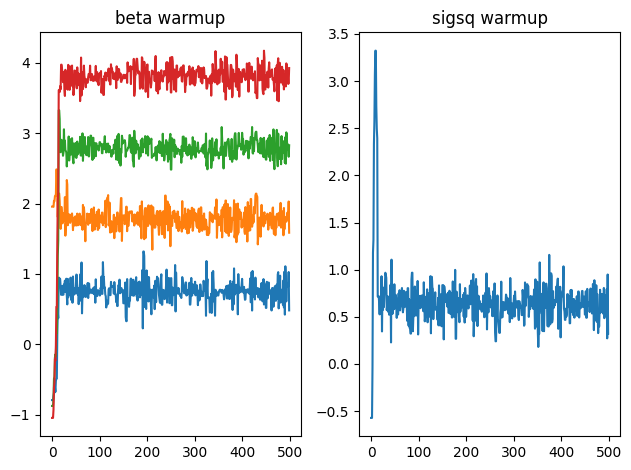

In [99]:
plt.subplot(1,2,1)
plt.plot(info[0].position.beta)
plt.title('beta warmup')
plt.subplot(1,2,2)
plt.plot(info[0].position.sigsq)
plt.title('sigsq warmup')
plt.tight_layout()

Named tuple for holding MCMC results, split into 2 half-chains

In [100]:
MCMCResults = namedtuple("MCMCResults", ['state1h', 'state2h', 'trace1h', 'trace2h'])

In [101]:
# single chain inference loop we will run in parallel using vmap
def inference_loop(rng_key, kernel, initial_state, num_samples) -> MCMCResults:
    def one_step(extended_state, idx):
        i_key, carry_key = jax.random.split(extended_state.rng_key)
        chain_state, _ = kernel(i_key, extended_state.state)
        e = X @ chain_state.position.beta - y
        elpd_contrib = -0.5 * (
            jnp.log(2 * jnp.pi)
            + jnp.log(chain_state.position.sigsq)
            + jnp.dot(e, e)/chain_state.position.sigsq
        )
        carry_welford_state = welford_add(extended_state.welford_state, elpd_contrib)
        carry_state = ExtendedState(chain_state, carry_key, carry_welford_state)
        return carry_state, chain_state  # we'll eventually drop chain state and return None instead
    # split the chain
    initial_state_1h = ExtendedState(initial_state, rng_key, welford_init(0))
    #carry_state_1h = jax.lax.fori_loop(0, num_samples//2, one_step, initial_state_1h)
    carry_state_1h, states_1h = jax.lax.scan(one_step, initial_state_1h, jnp.arange(num_samples//2))
    initial_state_2h = ExtendedState(initial_state_1h.state, initial_state_1h.rng_key, welford_init(0))
    #carry_state_2h = jax.lax.fori_loop(0, num_samples//2, one_step, carry_state_1h)
    carry_state_2h, states_2h = jax.lax.scan(one_step, carry_state_1h, jnp.arange(num_samples//2, num_samples))
    return MCMCResults(carry_state_1h, carry_state_2h, states_1h, states_2h)

In [102]:
# smoke test a single chain
res = inference_loop(sampling_key, kernel, final_warmup_state, num_samples)

In [103]:
%%time

sampling_keys = jax.random.split(sampling_key, num_chains)

res = jax.vmap(inference_loop, in_axes=(0, None, 0, None))(
    sampling_keys, kernel, initial_states, num_samples)

CPU times: user 2min 55s, sys: 30.6 ms, total: 2min 55s
Wall time: 2min 55s


In [118]:
res.state1h.state

HMCState(position=Theta(beta=Array([[0.48416573, 1.9397656 , 2.6052883 , 3.914477  ],
       [0.9792518 , 1.66251   , 2.799564  , 3.613375  ],
       [0.6277796 , 1.6564468 , 2.797722  , 3.8103828 ],
       [1.0593421 , 1.6748048 , 2.6630936 , 3.9968758 ],
       [0.94728774, 1.8232564 , 2.7866573 , 3.8082654 ],
       [0.67833555, 1.5200427 , 2.7849824 , 3.878126  ],
       [0.6588242 , 1.8078678 , 2.9327288 , 4.0876255 ],
       [0.9165713 , 1.5888029 , 2.9345512 , 3.955148  ],
       [0.90342546, 1.7511022 , 2.4894533 , 3.9552505 ],
       [0.84858435, 1.5725776 , 2.777351  , 3.8785045 ],
       [0.5373075 , 1.8253487 , 2.7579026 , 4.0558314 ],
       [0.6081923 , 1.7739159 , 2.651623  , 3.8387854 ],
       [0.9582368 , 1.4799421 , 2.7983239 , 3.6366127 ],
       [0.6801074 , 1.8309165 , 2.8758814 , 3.9184313 ],
       [0.9503886 , 1.7380656 , 2.5570567 , 3.7587032 ],
       [0.63289654, 1.6855782 , 3.068218  , 3.8602326 ],
       [0.6395595 , 1.8166933 , 2.5905662 , 3.58705   ],
  

In [107]:
def split_rhat(results: MCMCResults) -> float:
    # split chain means
    means = jnp.hstack([
        jax.vmap(welford_mean)(results.state1h.welford_state),
        jax.vmap(welford_mean)(results.state2h.welford_state)])
    # split chain sample variances
    vars = jnp.hstack([
        jax.vmap(welford_var)(results.state1h.welford_state),
        jax.vmap(welford_var)(results.state2h.welford_state)])
    W = jnp.mean(vars)
    # number of draws per split chain (ie half draws in an original chain)
    n = results[0].welford_state.n[0]
    # number of split chains
    m = len(means)
    B = n*jnp.var(means, ddof=1)
    varplus = (n-1)/n*W + B/n
    Rhat = jnp.sqrt(varplus/W)
    return Rhat

In [108]:
split_rhat(res)

Array(0.99989665, dtype=float32)

In [116]:
ipos = make_initial_pos(init_key, jnp.array(0.))
jax.vmap(lambda x: welford_init(0.*x))(ipos)

ValueError: vmap was requested to map its argument along axis 0, which implies that its rank should be at least 1, but is only 0 (its shape is ())

In [114]:
ipos

Theta(beta=Array([-0.7934547,  1.9556084, -0.8765542, -1.0467958], dtype=float32), sigsq=Array(-0.5725222, dtype=float32), post_id=0.0)